In [ ]:
%pip install scvi-tools

# General imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from tqdm import tqdm
import string
from scipy.stats import nbinom
import numpy.typing as npt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"{device=:}")

torch.manual_seed(42)
np.random.seed(38)
random.seed(38)

plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["pdf.fonttype"] = 42


from orion.utils.vae_functions import train_orion_model
from orion.utils.xgboost_functions import feature_selection_xgb
from orion.utils.preprocessing import get_or_table, to_onehot
from orion.utils.reporting import plot_roc, plot_stratified_sensitivities

device=cpu


# Defining notebook functions

In [ ]:
def make_samplemap(
        perfdf: pd.DataFrame, metadf: pd.DataFrame,
        select_col: str = "stage_simple"):
    """
    Makes a dictionary of sample indices and values in a specific
    column. Will enfoirce label==False to be considered as normal.

    args
    ----
    perfdf : pd.DataFrame
        Performance dataframe with sample indices as index
    metadf : pd.DataFrame
        Metadata dataframe with sample indices as index
        It should have the column `label` as binary label
        It should also contain the categorical column `select_col`
    select_col : str

    returns
    -------
    sample_map : dict
        Dictionary of sample indices and values in `select_col`
    """
    assert select_col in metadf.columns, "Column name is wrong"
    assert "label" in metadf.columns, "Requires binary label column"
    metadf_temp = metadf.copy()
    perfdf_temp = perfdf.copy()
    # set the label top normal
    metadf_temp[select_col][metadf_temp["label"] == False] = "normal"
    # transfer to perfdf
    perfdf_temp[select_col] = metadf_temp.loc[perfdf_temp.index, select_col]
    sample_map = dict(zip(perfdf_temp.index, perfdf_temp[select_col].map(str)))
    return sample_map


def select_features_orion_or(
        cpm_df: pd.DataFrame,
        train_index: npt.ArrayLike,
        y_array: npt.ArrayLike,
        meta_df: pd.DataFrame):
    """Select features based on odds ratio and p-value

    args
    ----
    cpm_df : pd.DataFrame
        Counts per million dataframe
    train_index : npt.ArrayLike
        Indices of training samples
    y_array : npt.ArrayLike
        Binary labels
    meta_df : pd.DataFrame
        Metadata dataframe
    
    returns
    -------
    select_features : np.ndarray
        Selected features
    """
    assert np.all(meta_df.index == cpm_df.index), "indices do not match"
    assert max(train_index) < meta_df.shape[0], "Metadata doesn't match"
    statdf = get_or_table(cpm_df, y_array, train_index)
    statdf = statdf[statdf["Case.Cancer.frac"] > 0.02]
    select_features = statdf.index[
        np.logical_and(
            statdf["Case.Cancer.log.OR"] > 0, statdf["Cancer.pValue"] <= 1
        )
    ]
    print("After OR filtering, using {} oncRNAs".format(len(select_features)))
    return select_features


def select_features_orion(
        cpm_df: pd.DataFrame,
        train_index: npt.ArrayLike,
        test_index: npt.ArrayLike,
        y_array: npt.ArrayLike,
        meta_df: pd.DataFrame):
    """Feature selection with odds ratio filtering and iterative xgboost

    args
    ----
    cpm_df : pd.DataFrame
        Counts per million dataframe
    train_index : npt.ArrayLike
        Indices of training samples
    test_index : npt.ArrayLike
        Indices of testing samples
    y_array : npt.ArrayLike
        Binary labels
    meta_df : pd.DataFrame
        Metadata dataframe
    
    returns
    -------
    select_features : np.ndarray
    """
    assert np.all(meta_df.index == cpm_df.index), "indices do not match"
    assert max(train_index) < meta_df.shape[0], "Metadata doesn't match"
    statdf = get_or_table(cpm_df, y_array, train_index)
    statdf = statdf[statdf["Case.Cancer.frac"] > 0.02]
    select_features = statdf.index[
        np.logical_and(
            statdf["Case.Cancer.log.OR"] > 0, statdf["Cancer.pValue"] <= 1
        )
    ]
    print(f"Using {select_features.shape} oncRNAs")
    cpm_df = cpm_df.T.loc[select_features].T
    if len(select_features) < 2000:
        print(f"Using {select_features.shape} features")
    else:
        # perform 3 rounds of xgboost
        select_features = feature_selection_xgb(
            cpm_df,
            train_index,
            test_index,
            np.array(meta_df["cohort"] == "CANC"),
            n_times=3,
        )
        print(f"Found {select_features.shape} features with xgboost")
    return select_features


def simulate_matrix(
    n_rows=1000, n_cols=1000, name_length=10, prob_param=0.2, dropout=0.9
):
    """
    Simulates a matrix with random names and negative binomial distribution.

    Args:
        size: Size of the matrix (rows and columns). Defaults to 1000.
        name_length: Length of random names in the matrix. Defaults to 10.
        size_param: Size parameter for the negative binomial distribution. Defaults to 10.
        prob_param: Probability parameter for the negative binomial distribution. Defaults to 0.2.

    Returns:
        A numpy array with the simulated matrix.
    """
    matrix = np.zeros((n_rows, n_cols), dtype=object)

    size_params = np.random.choice(np.arange(1, 100), n_cols)

    col_names = [
        "".join(
            random.choices(
                string.ascii_uppercase + string.digits, k=name_length
            )
        )
        for _ in range(n_cols)
    ]
    row_names = [
        "".join(
            random.choices(
                string.ascii_uppercase + string.digits, k=int(name_length / 2)
            )
        )
        for _ in range(n_rows)
    ]

    # Generate negative binomial values
    for i in tqdm(
        range(n_cols), desc=f"Simulating reads with {dropout} dropout"
    ):
        # Use for 10% of samples
        j_samples = np.random.choice(np.arange(n_rows), int(n_rows * dropout))
        matrix[j_samples, i] = [
            nbinom.rvs(size_params[i], prob_param) for each in j_samples
        ]
    out_df = pd.DataFrame(matrix, index=row_names, columns=col_names)
    return out_df

# Simulating the data

In [ ]:
onc_mat = simulate_matrix(n_cols=200, n_rows=1000, dropout=0.9)
mir_df = simulate_matrix(n_cols=200, n_rows=1000, dropout=0.4)
mir_df.index = onc_mat.index
onc_mat.head()

Simulating reads with 0.4 dropout: 100%|██████████| 200/200 [00:03<00:00, 53.91it/s]


,XP0CZNVGMJ,L0R8UIWTFS,ANTY8WARJ0,6D1KGQPKJP,YFNI0I0B4P,724B0S5UM6,9HFPXFVT2F,FS1V0JBYXA,DZXHJPAKIB,S7CYWKX1JO,WPGOZVLKGY,2IWCGVNPBS,RIWIMD5U6M,1YB7SLNJ1P,PPYVIU8N44,Q9JIOECMRV,5UTAASJ93F,B380C6Y5XY,6OGGN24PHE,K4CW8TZBQZ,FKR3UWSJ81,B91D19NVEK,HGKIVY99A4,KN8F7K8LSB,32K131D7MF,C7NF5FHVE7,BSAU4B444R,4I4Q9E81FX,MAT7BYA9W9,L4R4YR7IPU,1ZIS18SSBL,2PC5EG83NB,MKM0ZOA001,J7DRKLHS79,95N5W79FGF,4DEK6HNI2X,4Z3O6BA90B,YODM2NYG07,P54T3OSS3G,X0NNH0BXOJ,...,4TSWKELGDK,KOUZSPW6AB,1SIA1UMIVX,76MGFI42MR,YMRBLAK2KW,3ZRTL002FZ,BB8DWHZZYI,MFOV21LURZ,2RXYLQFSQ7,0DI6NO1T93,UE0YV82RZX,TC3TA5S3HD,Y1F7WJC9S3,JE9WMOQ27K,Q3CVN209GW,SN71CN2Y61,64IVLPAYWI,N6VPXO1J3B,NTOHQ4NU9L,3XUI3FJ54E,7G6HNM62TE,2VEL9E7JDU,XO6AE93KAH,MEHXE6ICAA,2PAIFN3L8A,R6PAHYGJ7R,0S4LKHR32D,YIZPV0W46D,ES32TJ56R3,KQPUY0KQX0,NX8OWHI1QO,8BU0B3Z2CH,C13XULOG2E,PXYU9SSORY,COJYBWFW0D,NPMEXXJX7F,5VCXE60L4X,ACDCRYMN4W,BUY373AQYB,5AKD86312P
5WA9L,0,0,214,337,266,15,25,389,0,345,400,0,0,287,27,0,268,0,45,212,209,105,191,0,0,0,204,0,103,257,40,205,0,0,0,305,325,108,320,144,...,486,97,0,0,237,0,33,320,0,176,0,345,289,0,303,3,0,170,299,13,0,173,239,309,141,0,51,126,284,415,174,2,388,127,61,206,0,245,134,390
MKG2U,124,0,201,332,0,0,0,365,107,0,329,437,372,228,0,432,271,312,46,182,0,0,158,117,0,0,193,353,119,376,50,181,400,319,145,0,430,98,225,112,...,0,120,301,0,311,0,51,253,0,0,0,379,207,197,0,19,154,198,276,11,157,178,258,317,0,0,0,0,0,412,134,0,340,104,62,0,242,252,142,271
6P1MT,155,0,213,0,0,38,20,0,0,383,0,0,282,0,50,0,0,240,58,234,0,0,0,0,0,0,0,355,111,293,0,262,388,0,143,0,426,0,236,0,...,408,95,324,0,228,367,46,368,297,182,378,298,0,234,338,12,118,157,298,9,0,242,0,258,104,0,61,0,411,332,144,0,406,139,0,0,240,233,0,0
067ED,138,375,0,291,0,0,0,489,0,222,0,341,357,0,53,462,350,0,65,218,0,68,177,98,0,0,0,315,132,0,57,219,0,0,219,232,0,0,333,0,...,439,0,0,227,236,420,51,316,289,172,367,356,0,0,278,0,187,125,248,24,217,0,0,256,151,380,0,0,0,344,0,0,392,0,67,0,0,0,187,385
1DZLT,155,0,184,0,219,30,11,405,108,300,429,351,0,318,71,359,249,309,0,0,180,0,0,93,0,0,0,0,132,272,31,193,404,0,214,222,0,0,0,0,...,398,0,354,233,299,335,0,0,0,175,0,0,0,202,323,14,0,0,0,0,0,0,250,0,0,0,0,0,358,383,161,0,0,138,51,0,0,263,0,340


# Example of small RNA data frame

In [ ]:
mir_df.head()

,NHVJYG4DBT,FIXQAREPRC,94F2SZG9TS,MOTDXSPJTD,ZUQUQP11E8,G9JFHY6LMC,CNB5GW80O4,5USOVODNQI,N9VTLTH928,9N0UDJ5GWQ,RD4AY4UW4X,DLTFMA7IPW,XOM9A8DHRP,5N2N9LPO28,XH6CAA0T95,79O5J2V8KW,03CDJ85GAF,T8CM1AM0QI,185E8BBKKC,4WS56HGASL,AG3E0LO42E,LYNO1U7116,V3W5AS5R9Z,ORBKX1Y2DT,C4U93XK91V,3CJOQK0S4D,JJY5WE23W1,Z3SQUJRMS8,C4WBC63PNR,3R5OBDAA5R,GLVI75D6K0,XOR6HQ44Y0,93NSVSP2A4,TD8T4AJCCS,EEQOSR7QR6,6WQ4D49CN5,CF36OPZYO4,V4BUKRW0VA,W8DFAYH182,741UTI9EFP,...,AOZNFVPDFU,PZZ91VTW25,RHFIHB1QJI,50T4Y9KENE,LCGKQ4MJBV,8TWTCW5ETV,XJ7WBBQ9QG,OAD4XO9BSD,XJKLNR6KK9,D8MJ1W86HY,CWG6NOFPYF,8LX58YXPKP,1JVPQVQP5H,G1FBVXB6VV,8N0G7TGAR6,XRBQTNW08A,HB14ZDJ0G4,3TH5C0OBUH,WI2Q4ST7O7,I1775GBERR,NEBRDAZ9CV,17GJHCV9QT,MR94I9MJBS,M41WBLWBJ0,C8CJYO8H9M,SOJK405YBQ,8GIQWTB582,T8W2ZJ9M89,II0TFC3UU7,ELDQK1V1HA,YEPO5PWV6X,SWL6LOG3SY,CZ6YPSLAEE,CXK753EU68,USPJ36Z5RZ,9DKZNCHCDR,9AIJ6VUDUA,PO8Y0M8SFH,Z9AP6PXYXB,39VLXXKHED
5WA9L,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,60,0,0,0,0,0,0,0,0,125,0,272,0,24,0,0,0,339,15,304,0,0,0,0,...,0,171,0,369,25,0,0,0,0,333,0,0,0,0,0,0,126,0,307,191,253,52,0,0,0,0,0,205,385,0,0,0,120,0,0,0,0,0,0,0
MKG2U,0,0,0,0,135,43,0,130,0,0,0,59,0,0,127,0,44,287,0,0,0,0,0,0,0,160,0,0,0,0,0,113,0,321,0,0,0,0,0,328,...,0,0,0,414,0,0,353,0,372,0,0,191,0,0,179,0,105,0,0,0,0,0,0,0,319,0,179,192,0,0,0,0,0,0,0,0,0,212,0,0
6P1MT,0,0,0,0,108,14,0,0,0,373,0,0,83,135,0,0,0,0,0,173,0,0,125,46,0,0,0,0,0,0,7,82,0,0,0,243,288,0,0,0,...,186,0,0,0,0,254,0,0,318,0,0,155,0,0,0,0,104,0,0,112,0,0,0,104,368,0,250,189,0,0,302,242,0,285,172,353,401,0,0,0
067ED,0,0,0,0,0,0,0,123,0,0,0,0,68,0,0,0,0,0,264,0,0,0,97,0,0,140,59,0,49,0,0,0,0,0,9,0,0,0,0,0,...,0,181,0,436,47,364,501,0,366,0,0,167,0,0,0,0,109,122,0,0,0,48,0,79,0,0,0,0,268,0,269,0,0,292,193,0,403,262,0,0
1DZLT,109,0,400,279,149,0,239,0,394,366,183,70,0,0,0,11,0,0,0,183,0,0,0,0,0,0,0,254,91,36,0,124,0,0,0,0,226,0,0,245,...,166,135,0,0,0,274,0,0,368,0,0,177,53,0,0,121,0,0,186,0,0,0,264,97,0,0,194,207,297,146,311,373,0,362,0,0,0,0,0,0


# Defining a hypothetical metadata with stage and cohort information

In [ ]:
meta_df = pd.DataFrame(
    {
        "read_dedup_mapped": np.apply_along_axis(np.sum, axis=1, arr=mir_df),
        "simple_stage": np.random.choice(
            ["I", "II", "III", "IV"], onc_mat.shape[0], replace=True
        ),
        "simple_tscore": np.random.choice(
            ["T1", "T2", "T3", "T4"], onc_mat.shape[0], replace=True
        ),
        "patient_cohort": np.random.choice(
            ["Control", "Cancer"], onc_mat.shape[0], replace=True
        ),
        "supplier": np.random.choice(
            ["Supplier 1", "Supplier 2"], onc_mat.shape[0], replace=True
        ),
    },
    index=onc_mat.index,
)
control_samples = meta_df.index[meta_df["patient_cohort"] == "Control"]
cancer_samples = meta_df.index[meta_df["patient_cohort"] == "Cancer"]

meta_df["label"] = 1
meta_df.loc[control_samples, "label"] = 0
meta_df.loc[control_samples, "simple_stage"] = "normal"
meta_df.loc[control_samples, "simple_tscore"] = "normal"
samples_to_set_as_control = np.union1d(
    np.random.choice(control_samples, int(len(control_samples) * 0.8)),
    np.random.choice(cancer_samples, int(len(cancer_samples) * 0.05)),
)
onc_mat.loc[samples_to_set_as_control] = np.array(
    onc_mat.loc[samples_to_set_as_control] * 0.3, dtype=int
)
meta_df.head()

,read_dedup_mapped,simple_stage,simple_tscore,patient_cohort,supplier,label
5WA9L,11187,III,T4,Cancer,Supplier 1,1
MKG2U,12028,normal,normal,Control,Supplier 1,0
6P1MT,13028,III,T2,Cancer,Supplier 1,1
067ED,12985,normal,normal,Control,Supplier 1,0
1DZLT,14538,I,T3,Cancer,Supplier 2,1


# Defining an RNA-normalized dataframe for feature selection

In [ ]:
meta_df["reads_mirna"] = np.apply_along_axis(
    np.sum, arr=mir_df.loc[meta_df.index], axis=1
)
cpm_df = np.divide(onc_mat.T, meta_df.loc[onc_mat.index, "reads_mirna"]).T * 1e3

print(cpm_df.shape)

select_oncrnas = cpm_df.columns
cpm_df = cpm_df.T.loc[select_oncrnas].T
print(cpm_df.shape)

use_oncs = []
for i, each in enumerate(cpm_df.columns):
    if np.sum(cpm_df.iloc[:, i]) > 0:
        use_oncs.append(each)
    if i % 100000 == 0:
        print("Examined {}/{} oncRNAs".format(i, cpm_df.shape[1]))
cpm_df = cpm_df.T.loc[use_oncs].T
cpm_df.shape

(1000, 200)
(1000, 200)
Examined 0/200 oncRNAs


(1000, 200)

# Defining the dictionary of data for Orion

In [ ]:
batch_ar = np.array(pd.factorize(meta_df["supplier"])[0])
onehot_ar = to_onehot(np.array(meta_df["label"]))

merged_dict_data = {
    "oncrna_ar": np.array(onc_mat, dtype=float),
    "oncrna_names": np.array(onc_mat.columns),
    "patient_names": np.array(onc_mat.index),
    "onehot_ar": onehot_ar,
    "smrna_names": np.array(mir_df.columns),
    "smrnamat": np.array(mir_df, dtype=float),
    "batch_list": batch_ar,
}
for key, val in merged_dict_data.items():
    print("{} has dimension {}".format(key, val.shape))

oncrna_ar has dimension (1000, 200)
oncrna_names has dimension (200,)
patient_names has dimension (1000,)
onehot_ar has dimension (1000, 2)
smrna_names has dimension (200,)
smrnamat has dimension (1000, 200)
batch_list has dimension (1000,)


# Splitting the data randomly into training and test set

In [ ]:
train_idx, tune_idx = train_test_split(
    np.arange(meta_df.shape[0]), test_size=0.5, random_state=42
)
cancer_vec = np.array(meta_df["label"])
train_samples = meta_df.index[train_idx]
tune_samples = meta_df.index[tune_idx]

# performing feature selection within the training set
select_features = select_features_orion(
    cpm_df, train_idx, tune_idx, cancer_vec, meta_df
)
modelname = "Orion simulated data"
adname = modelname.replace(" ", "_")

Adding p-values for 200 oncRNAs
Using (95,) oncRNAs
Using (95,) features


# Defining the dictionary of hyperparameters of Orion

In [ ]:
oncrna_ar = merged_dict_data["oncrna_ar"]
xlib = merged_dict_data["smrnamat"]
n_hidden = min([1500, int(len(select_features) / 2)])

# (see inline comments of `orion/utils/modelparams.py` scriptsfor details)
dict_params = {
    "n_input": len(select_features),
    "n_input_lib": xlib.shape[1],
    "dp": 0.5,
    "loss_scalers": [10000, 1, 0.1, 0.001],
    "lr": 0.001,
    "n_hidden": n_hidden,
    "num_lvs": 10,
    "bag": False,
    "n_features": len(select_features),
    "n_layers": 1,
    "num_epochs": 50,
    "mixed_precision": False,
    "inject_lib": True,
    "mini_batch": 256,
    "tm_rounds": 8,
    "num_classes": 2,
    "weight_sample_loss": False,
    "use_generative_sampling": True,
    "use_best": False,
}

# Training orion model

In [ ]:
trained_model_dict = train_orion_model(
    merged_dict_data,
    train_idx,
    tune_idx,
    select_features,
    dict_params=dict_params,
)
# Obtaining performance scores of the tuning set (not used in training)
perfdf = trained_model_dict["perfdf_tune"]
dict_train = trained_model_dict["dict_train"]
dict_tune = trained_model_dict["dict_tune"]

Using 500 indices for Training
oncrna_names is not subsetted
smrna_names is not subsetted
Using 500 indices for Tuning
oncrna_names is not subsetted
smrna_names is not subsetted
(95,)


orion/utils/vae_functions.py:79: UserWarning: CUDA is not available. Using CPU. 
  warnings.warn("CUDA is not available. Using CPU. ")


Using default value of random_seed
Using default value of l1
Using default value of l2
Using default value of grad_clip_max
Using default value of inject_lib_method
Using default value of add_batchnorm_lib
Using default value of generative_samples_num
Using default value of use_size_factor_key
Using default value of use_triplet_loss
Using default value of use_augmentator
Using default value of predict_classes
Using default value of scaler
Using default value of device
Using default value of add_regression_reconst
Using default value of log_variational
Using default value of gene_likelihood
Class 0: 257.0/500: 0.514
Class 1: 243.0/500: 0.486
VAE(
  (batch_norm_z): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (_inference_model): OrionInferenceModel(
    (_oncrna_encoder): VariationalEncoder(
      (_shared_encoder): Sequential(
        (fc_layer_0): Sequential(
          (0): Linear(in_features=95, out_features=47, bias=True)
          (1): BatchNorm1

# Loss convergence plots

In [ ]:
trainig_df = pd.DataFrame(trained_model_dict["training_logdf"])
trainig_df["Cohort"] = "Training"
tuning_df = pd.DataFrame(trained_model_dict["tuning_logdf"])
tuning_df["Cohort"] = "Tuning"
logdf = pd.concat([trainig_df, tuning_df]).reset_index(drop=True)

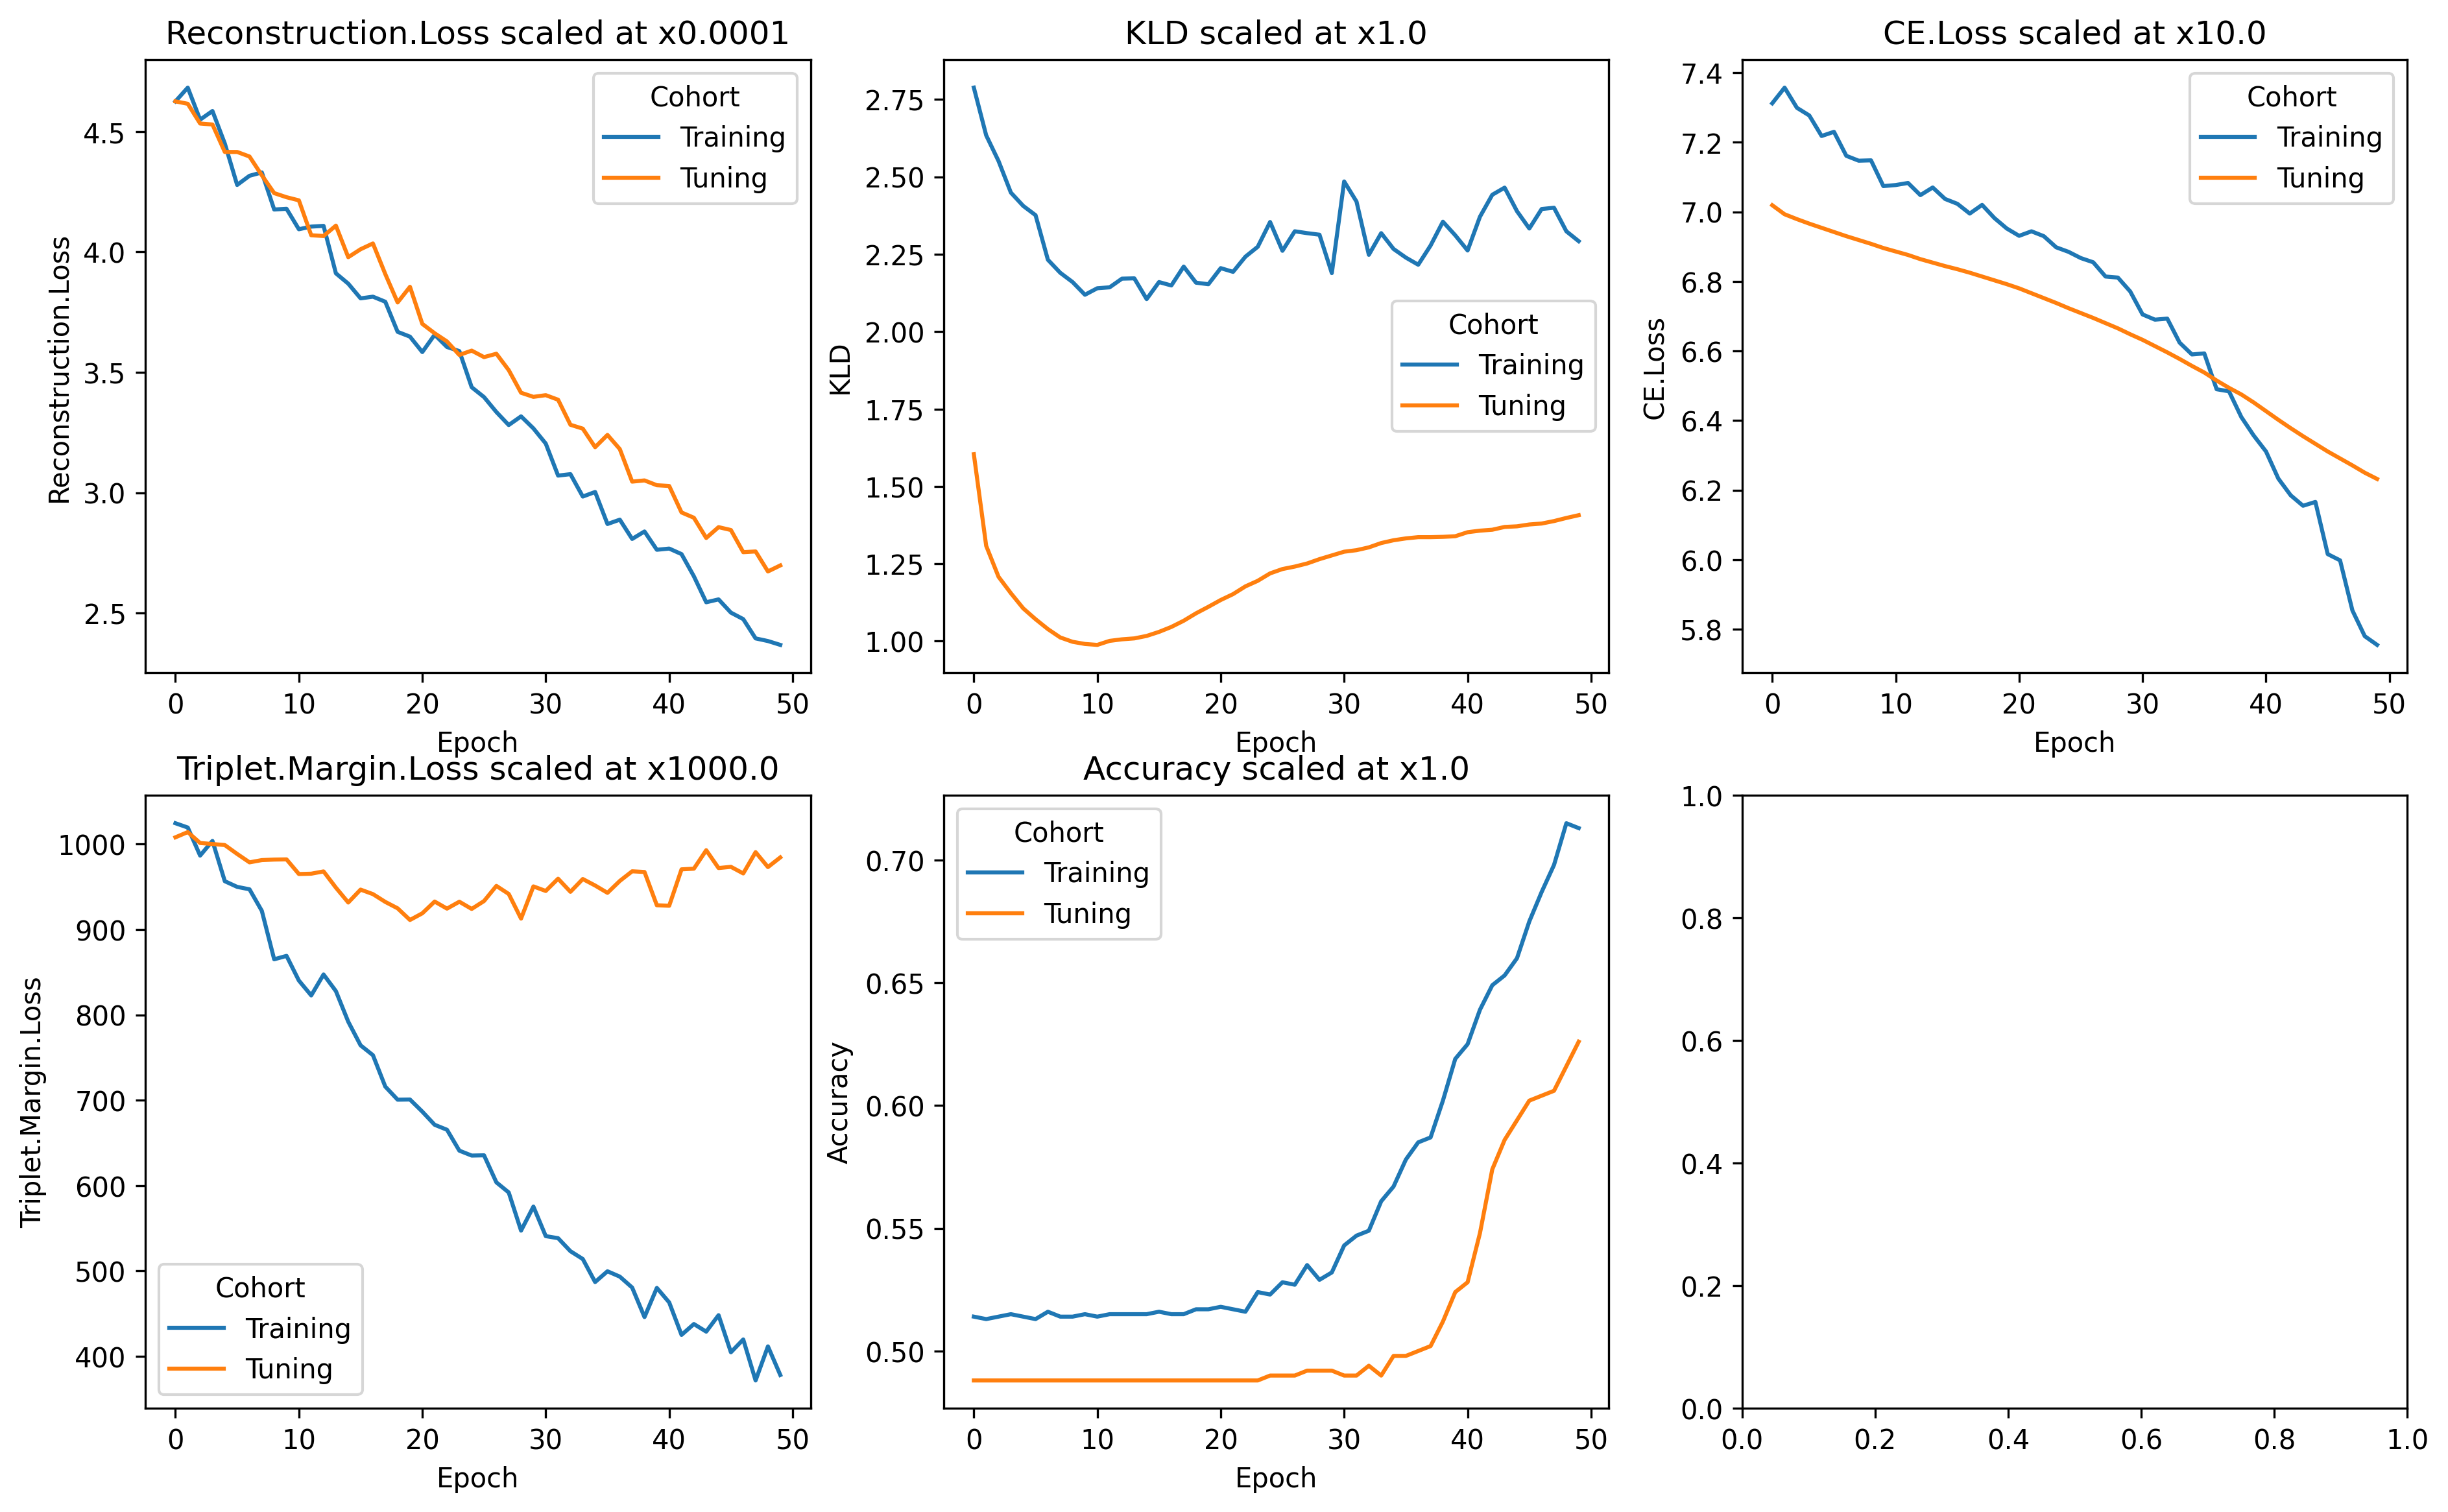

In [ ]:
select_vars = [
    "Reconstruction.Loss",
    "KLD",
    "CE.Loss",
    "Triplet.Margin.Loss",
    "Accuracy",
]
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 9), facecolor="white")
i = 0
j = 0
for k, lossname in enumerate(select_vars):
    scaler = dict_params["loss_scalers"][k]
    if scaler == 0:
        scaler = 1
    sns.lineplot(
        x=logdf["Epoch"], y=logdf[lossname], hue=logdf["Cohort"], ax=axs[i][j]
    ).set_title(f"{lossname} scaled at x{1 / scaler}")
    j += 1
    if j == 3:
        i += 1
        j = 0

# Example of accessing model objects (hyperparameters, embedding space, etc.)

In [ ]:
model_trainer_obj = trained_model_dict["model_train_obj"]
perfdf["model"] = modelname
perfdf["num.features"] = dict_train["oncrna_ar"].shape[1]
dict_details = {
    "name": modelname,
    "name_features": dict_train["oncrna_names"],
    "dict_train": dict_train,
    "dict_tune": dict_tune,
    "num_features": dict_train["oncrna_ar"].shape[1],
    "dim_train": dict_train["oncrna_ar"].shape,
    "dim_test": dict_tune["oncrna_ar"].shape,
    "mudf_train": trained_model_dict["mudf_train"],
    "mudf_tune": trained_model_dict["mudf_tune"],
}
for key, val in model_trainer_obj.dict_params.items():
    dict_details[key] = val

<Axes: xlabel='Cancer.Prob', ylabel='cancer_status'>

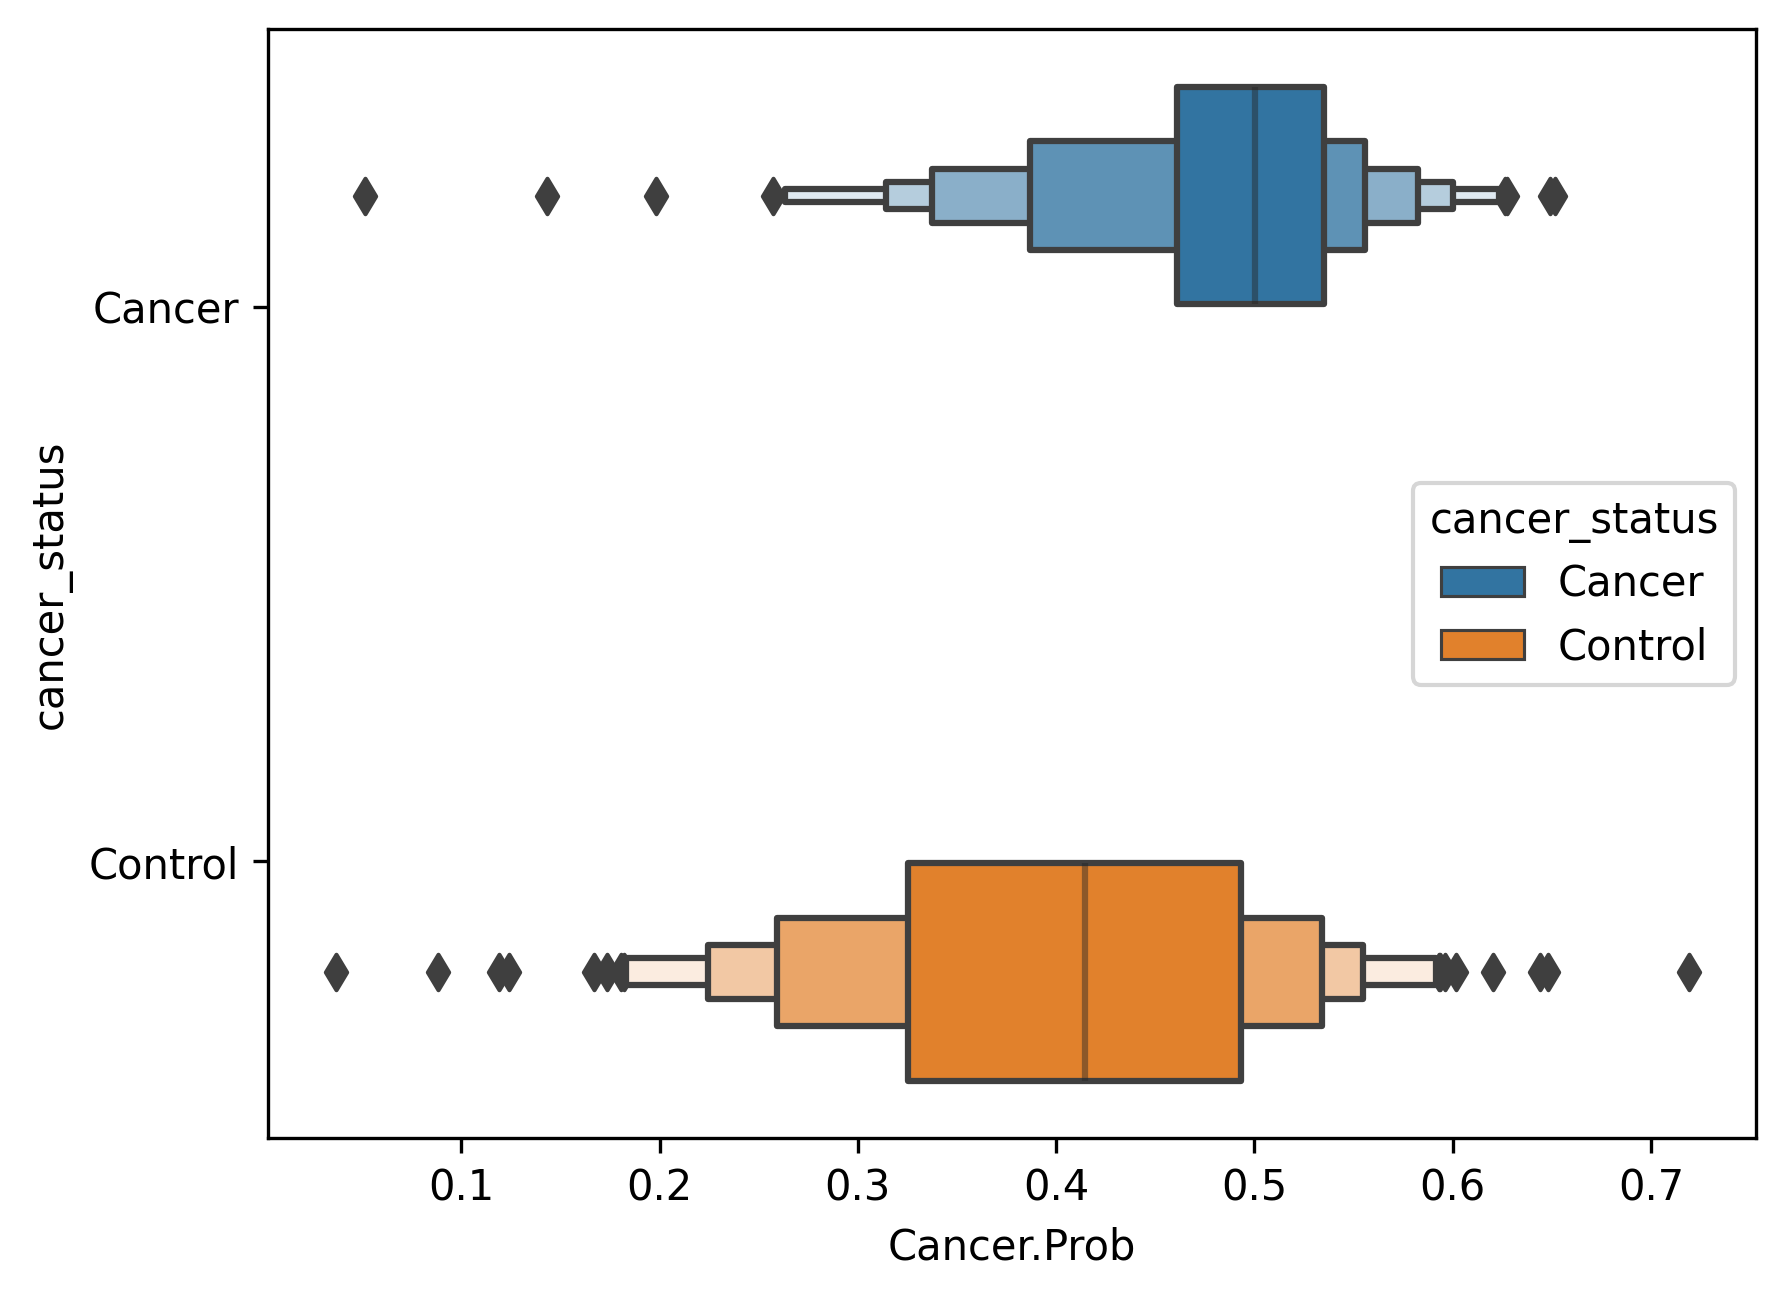

In [ ]:
perfdf["cancer_status"] = perfdf["label"].apply(
    lambda x: "Cancer" if x > 0.1 else "Control"
)
sns.boxenplot(
    data=perfdf, x="Cancer.Prob", y="cancer_status", hue="cancer_status"
)

# Example of a generic ROC plot for detection and sensitivity at a particular specificity

/root/.ipykernel/17008/command-2524719658846766-1266674725:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadf_temp[select_col][metadf_temp["label"] == False] = "normal"
/root/.ipykernel/17008/command-2524719658846766-1266674725:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadf_temp[select_col][metadf_temp["label"] == False] = "normal"


{'T1': (0.14285714285714285, (0.06375136555877284, 0.26221730209002503), 56),
 'T2': (0.05555555555555555, (0.0153425371111306, 0.13617864931292403), 72),
 'T3': (0.0967741935483871, (0.036349581692975204, 0.1988303762984588), 62),
 'T4': (0.10606060606060612, (0.043718449098592946, 0.20639348213238698), 66)}

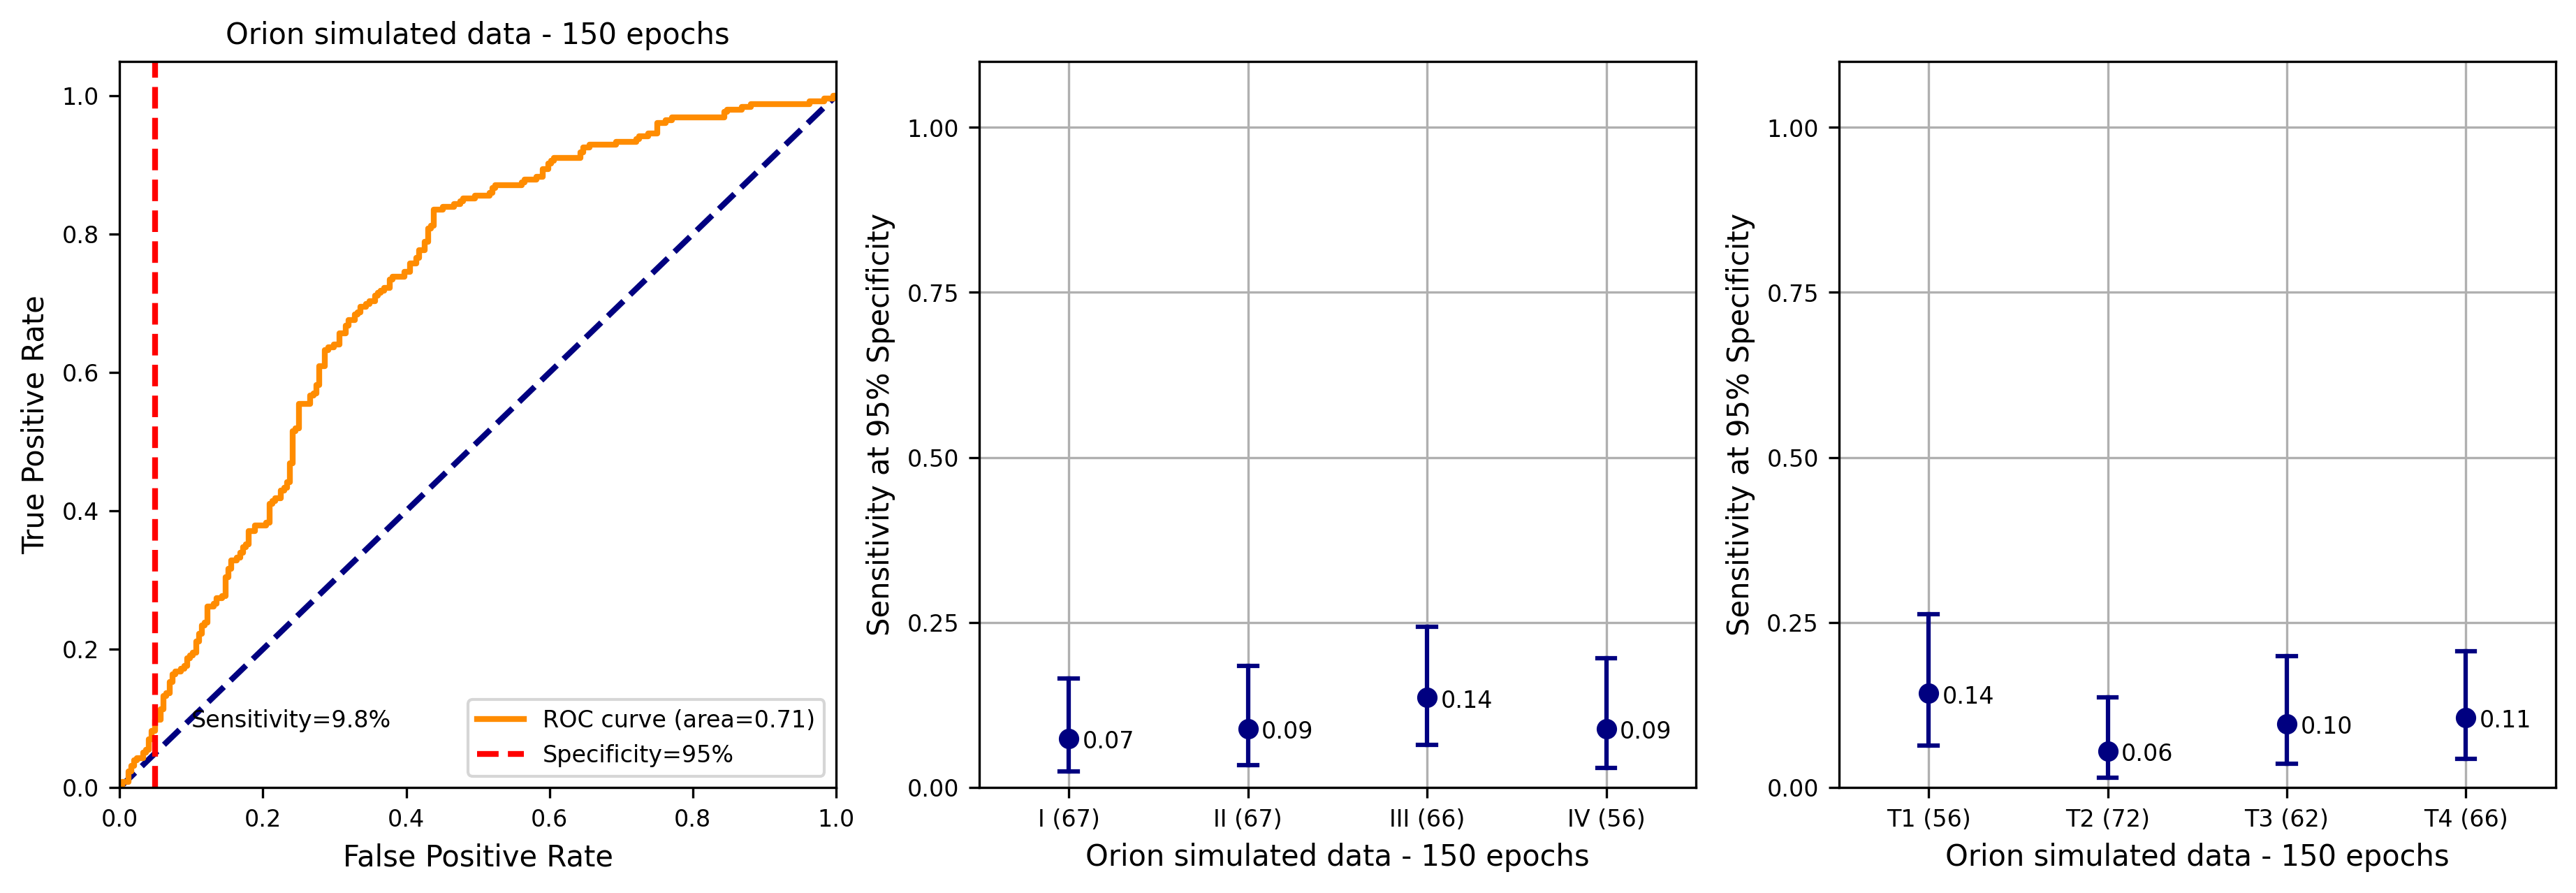

In [ ]:
perfdf["score"] = perfdf["Cancer.Prob"]
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 4.5), facecolor="white")
modelname = "Orion simulated data - 150 epochs"
j = 0
plot_roc(perfdf, ax=axs[j], title=modelname)
j += 1
dict_samplemap = make_samplemap(perfdf, meta_df, select_col="simple_stage")
plot_stratified_sensitivities(perfdf, dict_samplemap, axs[j], modelname)
j += 1
dict_samplemap = make_samplemap(perfdf, meta_df, select_col="simple_tscore")
plot_stratified_sensitivities(perfdf, dict_samplemap, axs[j], modelname)